# 🧪 Experiment: Setting Combination
This notebook conducts various experiments on the combination of different settings, which includes different datasets, gazettteers, and models.

**Note**: Before conducting experiments, you need to install `kaner` package first. Otherwise, this notebook will raise an *import error*.

```bash
cd ../
python setup.py install
```

In [13]:
import os
import pprint
from typing import List
from datetime import datetime
from collections import defaultdict

import matplotlib.pyplot as plt

from kaner.pipeline import train
from kaner.context import GlobalContext as gctx
from kaner.trainer import TrainerConfig
from kaner.tracker import NERTrackerRow, NERTracker
from kaner.common.func import query_time
from kaner.common import save_json

## 1 Define `trainall` Function

In [113]:
def trainall(labpath: str, cfgdir: str, m: List[str], d: List[str], g: List[str], n: int, tag: str, **kwargs) -> NERTracker:
    """
    Conducting experiments on all settings.

    Args:
        labpath (str): The file path of recording experimental results.
        cfgdir (str): Configuration folder.
        m (List[str]): All specific models to be trained.
        d (List[str]): All specific datasets to be tested.
        g (List[str]): All specific gazetteers to be tested.
        n (int): The number of training repeating times.
        tag (str): Experimental tags.
    """

    def update_names(names: List[str], all_names: List[str], name_type: str) -> List[str]:
        """
        Check whether the name that user inputs is correct.

        Args:
            names (List[str]): The names (dataset, model, gazetteer) that user inputs.
            all_names (List[str]): All names (dataset, model, gazetteer) that this libary provides.
            name_type (str): The type of the name (Dataset, Model, Gazetteer).
        """
        if len(names) == 0:
            names = all_names
        else:
            for name in names:
                if name not in all_names:
                    print("[{0}] {1} is not in {2}".format(name_type, name, all_names))
                    exit(0)
        return names

    tracker = NERTracker.load(labpath)
    models = update_names(m, gctx.get_model_names(), "Model")
    datasets = update_names(d, gctx.get_dataset_names(), "Dataset")
    gazetteers = update_names(g, gctx.get_gazetteer_names(), "Gazetteer")

    print("--------------------- Experiment Configuration ---------------------")
    print("Models: {0}".format(models))
    print("Datasets: {0}".format(datasets))
    print("Gazetteers: {0}".format(gazetteers))
    print("--------------------------------------------------------------------")

    for dataset in datasets:
        for model in models:
            for gazetteer_model in gazetteers:
                # avoid calculation repeatly
                if model in ["blcrf", "plmtg"]:
                    gazetteer_model = "gigaword"
                for _ in range(n):
                    if len(tracker.query(dataset=dataset, model=model, gazetteer_model=gazetteer_model, tag=tag)) >= n:
                        continue
                    config = TrainerConfig(os.path.join(cfgdir, model + ".yml"), dataset=dataset, gazetteer_model=gazetteer_model, **kwargs)
                    start = str(datetime.now())
                    try:
                        results, trainer = train(config)
                    except RuntimeError as error:
                        print(error)
                        continue
                    tracker.insert(
                        NERTrackerRow(
                            start, model, dataset, config.tokenizer_model, gazetteer_model, config.output_folder, query_time(trainer.train),
                            results["f1-score"], results["precision-score"], results["recall-score"], results["epoch_count"], results["test-loss"], tag
                        )
                    )
                    tracker.save(labpath)
                    del trainer

    return tracker

## 2 Given models, datasets, gazetteers, train them
You can find all available models, datasets and gazetteers by the following code block.

```python
models = gctx.get_model_names()
datasets = gctx.get_dataset_names()
gazetteers = gctx.get_gazetteer_names()
```

In [ ]:
labpath = "../data/logs/experiments.csv"
cfgdir = "../configs"
models = ["blcrf", "ses", "cgn", "mdgg"]
datasets = ["weiboner", "resumener", "ecommerce", "msraner", "ontonotes"]
gazetteers = ["gigaword", "sgns"]
n = 5
tag = "nil"
kwargs = {"data_folder": "../data"}

trainall(labpath, cfgdir, models, datasets, gazetteers, n, tag, **kwargs)

--------------------- Experiment Configuration ---------------------
Models: ['blcrf', 'ses', 'cgn', 'mdgg']
Datasets: ['weiboner', 'resumener', 'ecommerce', 'msraner', 'ontonotes']
Gazetteers: ['gigaword', 'sgns']
--------------------------------------------------------------------
[Dataset: ../data/datahub/ontonotes] 39446 train, 4930 dev, 4930 test. (resplit: False)


2020-09-29 07:39:56 [cgn, ontonotes] epoch: 0, no_improvement: 0, dev-f1: 0.45834, dev-precision: 0.58696, dev-recall: 0.37596, dev-loss: 5.32845, train-loss: 9.10181
2020-09-29 07:53:58 [cgn, ontonotes] epoch: 1, no_improvement: 0, dev-f1: 0.51164, dev-precision: 0.58472, dev-recall: 0.4548, dev-loss: 3.91787, train-loss: 4.42776
2020-09-29 08:07:52 [cgn, ontonotes] epoch: 2, no_improvement: 0, dev-f1: 0.52376, dev-precision: 0.60926, dev-recall: 0.45931, dev-loss: 3.35222, train-loss: 3.06694
2020-09-29 08:21:42 [cgn, ontonotes] epoch: 3, no_improvement: 0, dev-f1: 0.5682, dev-precision: 0.66154, dev-recall: 0.49794, dev-loss: 3.00812, train-loss: 2.34298
2020-09-29 08:35:24 [cgn, ontonotes] epoch: 4, no_improvement: 0, dev-f1: 0.63187, dev-precision: 0.64707, dev-recall: 0.61738, dev-loss: 2.88722, train-loss: 1.80732
2020-09-29 08:49:03 [cgn, ontonotes] epoch: 5, no_improvement: 0, dev-f1: 0.66707, dev-precision: 0.69023, dev-recall: 0.64542, dev-loss: 2.75038, train-loss: 1.43162


[Timing] kaner.trainer.base.train function took 40607.800 sec
# Save experimental data into ../data/logs/experiments.csv
[Dataset: ../data/datahub/ontonotes] 39446 train, 4930 dev, 4930 test. (resplit: False)


2020-09-29 18:57:30 [cgn, ontonotes] epoch: 0, no_improvement: 0, dev-f1: 0.48064, dev-precision: 0.54341, dev-recall: 0.43087, dev-loss: 5.339, train-loss: 8.74593
2020-09-29 19:11:22 [cgn, ontonotes] epoch: 1, no_improvement: 0, dev-f1: 0.53988, dev-precision: 0.57459, dev-recall: 0.50912, dev-loss: 3.95276, train-loss: 4.37809
2020-09-29 19:25:26 [cgn, ontonotes] epoch: 2, no_improvement: 0, dev-f1: 0.56401, dev-precision: 0.58621, dev-recall: 0.54344, dev-loss: 3.38334, train-loss: 3.04463
2020-09-29 19:39:31 [cgn, ontonotes] epoch: 3, no_improvement: 0, dev-f1: 0.60186, dev-precision: 0.60145, dev-recall: 0.60227, dev-loss: 3.08282, train-loss: 2.33282
2020-09-29 19:53:40 [cgn, ontonotes] epoch: 4, no_improvement: 0, dev-f1: 0.6344, dev-precision: 0.62634, dev-recall: 0.64268, dev-loss: 2.78202, train-loss: 1.85109
2020-09-29 20:07:37 [cgn, ontonotes] epoch: 5, no_improvement: 0, dev-f1: 0.6636, dev-precision: 0.64892, dev-recall: 0.67896, dev-loss: 2.74071, train-loss: 1.46514
20

[Timing] kaner.trainer.base.train function took 42290.842 sec
# Save experimental data into ../data/logs/experiments.csv
[Dataset: ../data/datahub/ontonotes] 39446 train, 4930 dev, 4930 test. (resplit: False)


2020-09-30 06:43:14 [cgn, ontonotes] epoch: 0, no_improvement: 0, dev-f1: 0.47676, dev-precision: 0.53725, dev-recall: 0.42852, dev-loss: 5.45688, train-loss: 8.7895
2020-09-30 06:57:20 [cgn, ontonotes] epoch: 1, no_improvement: 0, dev-f1: 0.52164, dev-precision: 0.57133, dev-recall: 0.4799, dev-loss: 3.90115, train-loss: 4.37731
2020-09-30 07:11:20 [cgn, ontonotes] epoch: 2, no_improvement: 0, dev-f1: 0.56273, dev-precision: 0.59815, dev-recall: 0.53128, dev-loss: 3.20847, train-loss: 3.08358
2020-09-30 07:25:33 [cgn, ontonotes] epoch: 3, no_improvement: 0, dev-f1: 0.58018, dev-precision: 0.60751, dev-recall: 0.55521, dev-loss: 3.06339, train-loss: 2.3758
2020-09-30 07:39:39 [cgn, ontonotes] epoch: 4, no_improvement: 0, dev-f1: 0.61012, dev-precision: 0.63609, dev-recall: 0.58619, dev-loss: 3.03397, train-loss: 1.85083
2020-09-30 07:53:44 [cgn, ontonotes] epoch: 5, no_improvement: 0, dev-f1: 0.64631, dev-precision: 0.59916, dev-recall: 0.70151, dev-loss: 2.90997, train-loss: 1.50497
2

## 3 Result Summary and Visualization

#0 Dataset: weiboner


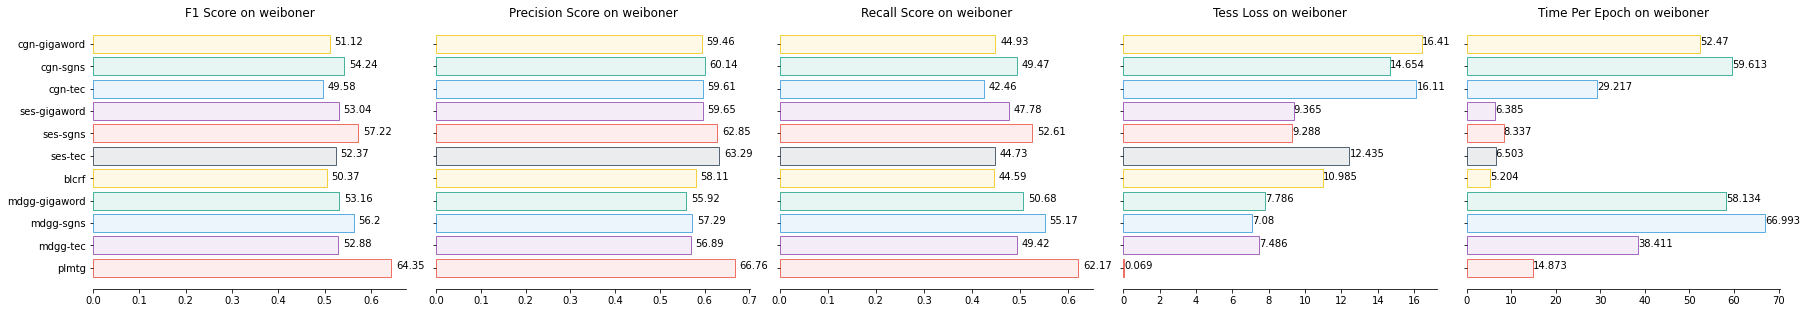

#1 Dataset: msraner


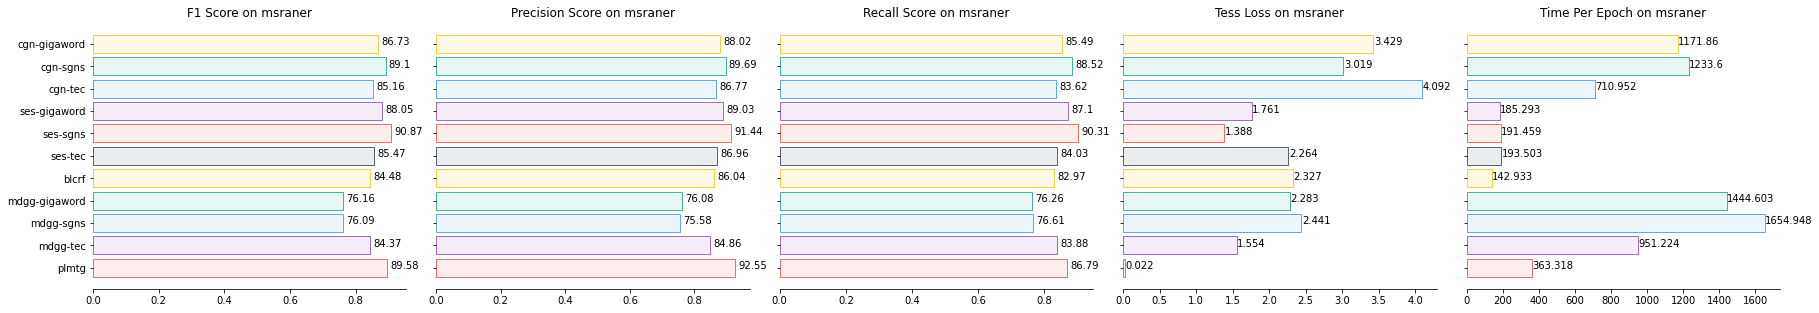

#2 Dataset: ecommerce


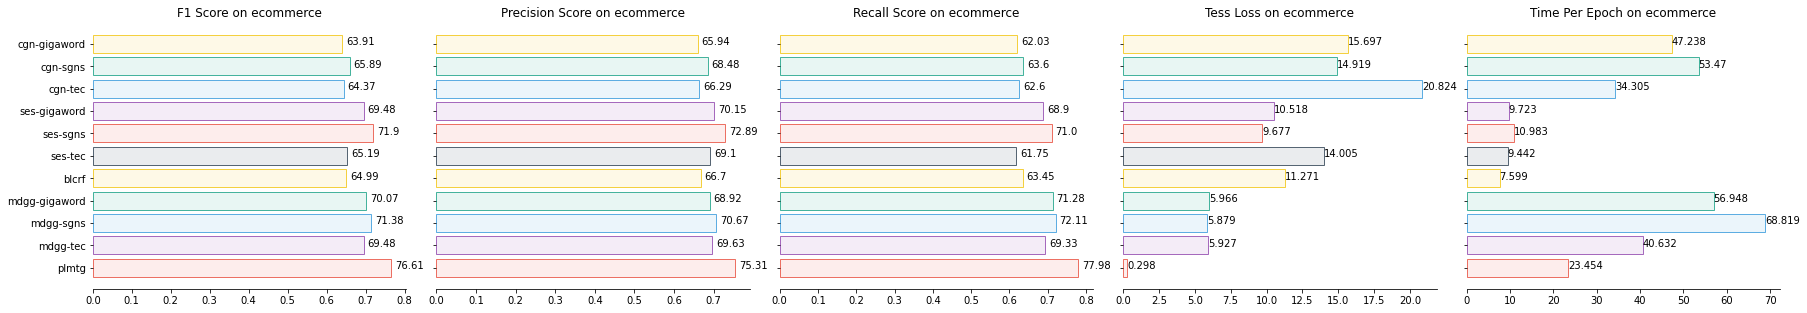

#3 Dataset: resumener


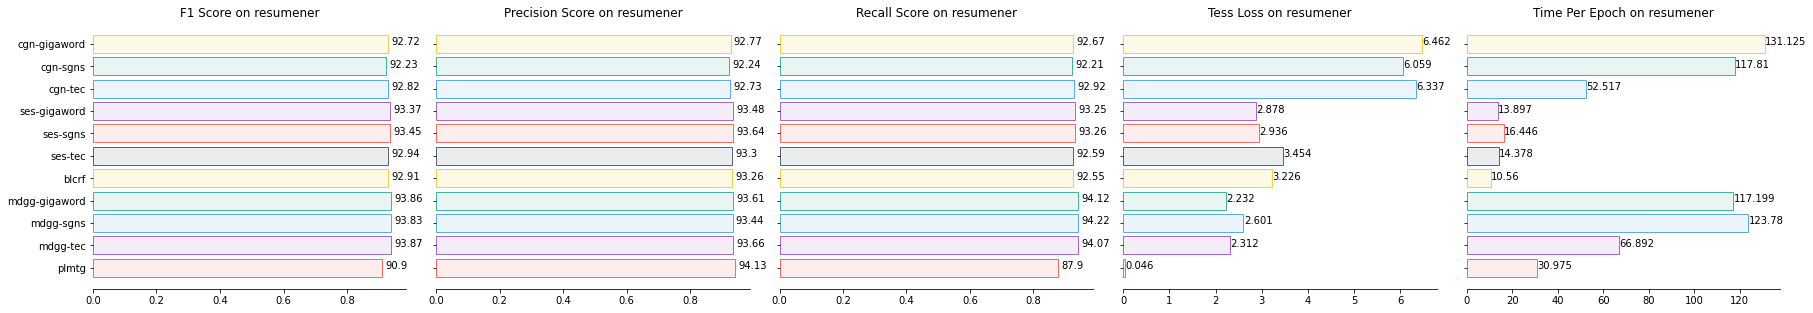

#4 Dataset: ontonotes


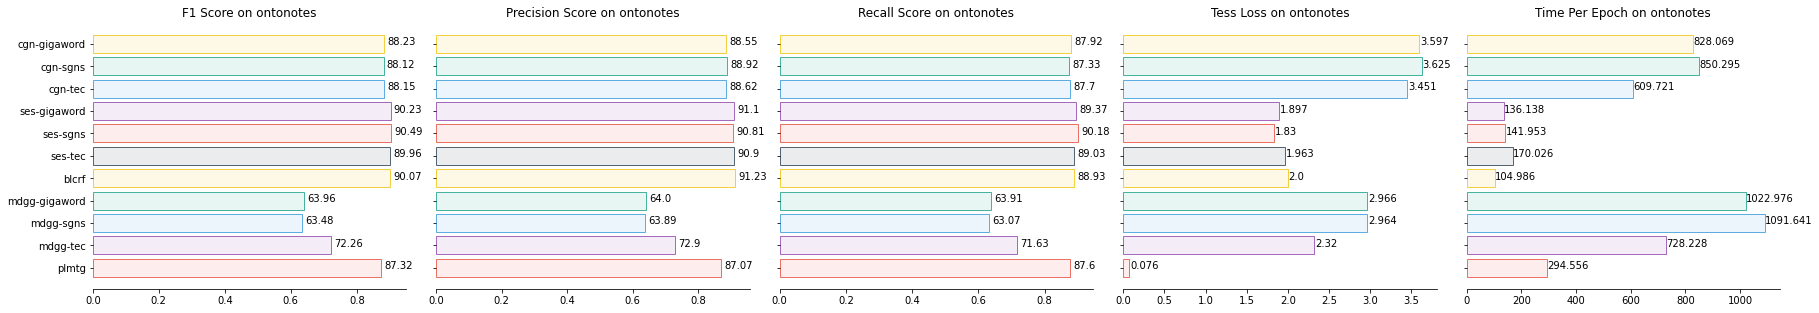

In [121]:
content_colors = ["#FDEDEC", "#F4ECF7", "#EBF5FB", "#E8F6F3", "#FEF9E7", "#EAECEE"]
edge_colors    = ["#EC7063", "#A569BD", "#5DADE2", "#45B39D", "#F4D03F", "#566573"]

# configuration
log_folder = "../data/logs/"
labpath = "../data/logs/experiments.csv"
tracker = NERTracker.load(labpath)
results = tracker.summay()
save_json(results, os.path.dirname(labpath), "experimental_summary.json")

reports = defaultdict(list)
for result in results:
    reports[result["dataset"]].append(result)
    
for i, (dataset, report) in enumerate(reports.items()):
    print("\x1b[6;30;42m#{0} Dataset: {1}\x1b[0m".format(i, dataset))
    x = ["{0}-{1}".format(r["model"], r["gazetteer_model"]) for _, r in enumerate(report)]
    for i, label in enumerate(x):
        if label.startswith(("blcrf", "plmtg")):
            x[i] = x[i].split("-")[0]
    fig, axs = plt.subplots(1, 5, sharey = True)
    fig.tight_layout(pad=0.05)
    fig.set_figwidth(25)
    # f1 score
    y = [r["f1_score"] for _, r in enumerate(report)]
    axs[0].barh(x, y, color=content_colors, edgecolor=edge_colors)
    axs[0].set_title("F1 Score on {0}".format(dataset))
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    for i, v in enumerate(y):
        axs[0].text(v + 0.01, i - 0.05, str(round(v*100, 2)))
    # precison score
    y = [r["precision_score"] for _, r in enumerate(report)]
    axs[1].barh(x, y, color=content_colors, edgecolor=edge_colors)
    axs[1].set_title("Precision Score on {0}".format(dataset))
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    for i, v in enumerate(y):
        axs[1].text(v + 0.01, i - 0.05, str(round(v*100, 2)))
    # recall score
    y = [r["recall_score"] for _, r in enumerate(report)]
    axs[2].barh(x, y, color=content_colors, edgecolor=edge_colors)
    axs[2].set_title("Recall Score on {0}".format(dataset))
    axs[2].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].spines['left'].set_visible(False)
    for i, v in enumerate(y):
        axs[2].text(v + 0.01, i - 0.05, str(round(v*100, 2)))
    # test loss
    y = [r["test_loss"] for _, r in enumerate(report)]
    axs[3].barh(x, y, color=content_colors, edgecolor=edge_colors)
    axs[3].set_title("Tess Loss on {0}".format(dataset))
    axs[3].spines['top'].set_visible(False)
    axs[3].spines['right'].set_visible(False)
    axs[3].spines['left'].set_visible(False)
    for i, v in enumerate(y):
        axs[3].text(v + 0.01, i - 0.05, str(round(v, 3)))
    # time per epoch
    y = [r["time_per_epoch"] for _, r in enumerate(report)]
    axs[4].barh(x, y, color=content_colors, edgecolor=edge_colors)
    axs[4].set_title("Time Per Epoch on {0}".format(dataset))
    axs[4].spines['top'].set_visible(False)
    axs[4].spines['right'].set_visible(False)
    axs[4].spines['left'].set_visible(False)
    for i, v in enumerate(y):
        axs[4].text(v + 0.01, i - 0.05, str(round(v, 3)))

    plt.show()
    fig.savefig(os.path.join(log_folder, "{0}_chart.pdf".format(dataset)))